In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import re
import os
import pandas as pd

from result_utils import *
import warnings

warnings.filterwarnings("ignore")


### Common function

In [2]:
sim_length = 29
results_dir = '../results/'
topo_dir = '../results/'
satellites_num = 61
link_bandwidth = 1000
dynamic_demands = True

demand_ratio = link_bandwidth / 20

gw_antenna_num = 8



#### holistic

In [3]:
AS = [[1, satellites_num + 3 * gw_antenna_num + 147]]
holistic_gw_indices = [x for x in range(satellites_num + 1, satellites_num + 3 * gw_antenna_num + 1)]
holistic_cell_indices = [x for x in range(satellites_num + 3 * gw_antenna_num + 1, satellites_num + 3 * gw_antenna_num + 1 + 147)]

holistic_change_file = 'holistic_small_2_topo_leo_change.txt'
holistic_results_dir = 'holistic_small_2'
holistic_delay_dir = 'holistic_small_2_delay/'

# Load cell demands
sat_cell_assignments = []
for gw_idx in range(3):
    assignment_csv = pd.read_csv(f'./sim_configs/small_2/sat_cell_assignments/gw0{gw_idx}_flows.csv')
    sat_cell_assignments.append(assignment_csv)

# Construct holistic assignments
holistic_assignments = np.zeros((sim_length, len(holistic_cell_indices)), dtype=int)
gw_assignments = np.genfromtxt(f'./sim_configs/small_2/cell_assignment.csv', delimiter=',', dtype=int)
for time_idx in range(sim_length):
    for cell_idx, _ in enumerate(holistic_cell_indices):
        target_gw_idx = gw_assignments[cell_idx]
        fac_idx = holistic_get_target_gs_idx(cell_idx, target_gw_idx, time_idx,
                                             sat_cell_assignments)
        holistic_assignments[time_idx, cell_idx] = fac_idx

holistic_demands = np.zeros((sim_length, len(holistic_cell_indices)), dtype=float)
for time_idx in range(sim_length):
    for cell_idx, _ in enumerate(holistic_cell_indices):
        target_gw_idx = gw_assignments[cell_idx]
        sat_cell_df = sat_cell_assignments[target_gw_idx]
        holistic_demands[time_idx, cell_idx] = float(sat_cell_df.loc[
            (sat_cell_df['time'] == time_idx) &
            (sat_cell_df['cell'] == cell_idx)
        ]['init_demand'].values[0]) * demand_ratio


holistic_change_file = topo_dir + holistic_change_file
holistic_change_matrix, holistic_change_time = construct_change_matrix(len(holistic_cell_indices), holistic_change_file, holistic_cell_indices, sim_length)

In [4]:
greedy_AS = [[1, satellites_num + 3 + 147]]
greedy_gw_indices = [x for x in range(satellites_num + 1, satellites_num + 3 + 1)]
greedy_cell_indices = [x for x in range(satellites_num + 3 + 1, satellites_num + 3 + 1 + 147)]

greedy_change_file_list = ['greedy_small_2_topo_leo_change.txt', 'greedy_hold_small_2_topo_leo_change.txt']
greedy_results_dir_list = ['greedy_small_2', 'greedy_hold_small_2']
greedy_delay_dir_list = ['greedy_small_2_delay/', 'greedy_hold_small_2_delay/']

# Load cell GW assignments
greedy_assignments_df_list = [pd.read_csv('./sim_configs/small_2/greedy_flows.csv'),
                           pd.read_csv('./sim_configs/small_2/greedy_hold_flows.csv')]

greedy_assignments_list = []
for i in range(2):
    assignment = np.zeros((sim_length, len(greedy_cell_indices)), dtype=int) - 1
    for time_idx in range(sim_length):
        for cell_idx in range(len(greedy_cell_indices)):
            assignment[time_idx, cell_idx] = int(greedy_assignments_df_list[i].loc[
                (greedy_assignments_df_list[i]['time'] == time_idx) &
                (greedy_assignments_df_list[i]['cell'] == cell_idx)
            ]['gw'].values[0])
    greedy_assignments_list.append(assignment)

# demands configuration
greedy_demands_list = []
for i in range(2):
    demands = np.zeros((sim_length, len(greedy_cell_indices)), dtype=float)
    for time_idx in range(sim_length):
        for cell_idx in range(len(greedy_cell_indices)):
            demands[time_idx, cell_idx] = float(greedy_assignments_df_list[i].loc[
                (greedy_assignments_df_list[i]['time'] == time_idx) &
                (greedy_assignments_df_list[i]['cell'] == cell_idx)
            ]['init_demand'].values[0]) * demand_ratio
    greedy_demands_list.append(demands)


greedy_change_matrix_list = []
greedy_change_time_list = []

for topo_file in greedy_change_file_list:
    change_file = topo_dir + topo_file
    change_matrix, change_time = construct_change_matrix(len(greedy_cell_indices), change_file, greedy_cell_indices, sim_length)
    greedy_change_matrix_list.append(change_matrix)
    greedy_change_time_list.append(change_time)

## Throughput

### Across algorithms

In [5]:
cell_indices_list = [greedy_cell_indices, greedy_cell_indices, holistic_cell_indices, holistic_cell_indices]
gw_indices_list = [greedy_gw_indices, greedy_gw_indices, holistic_gw_indices, holistic_gw_indices]

change_matrix_list = greedy_change_matrix_list + [holistic_change_matrix, holistic_change_matrix]
change_time_list = greedy_change_time_list + [holistic_change_time, holistic_change_time]

demands_list = greedy_demands_list + [holistic_demands, holistic_demands]
assignments_list = greedy_assignments_list + [holistic_assignments, holistic_assignments]

results_dir_list = greedy_results_dir_list + [holistic_results_dir, holistic_results_dir]
delay_dir_list = greedy_delay_dir_list + [holistic_delay_dir, holistic_delay_dir]

handover_types = ['CU-1', 'DU-1', 'CU-1', 'DU-2']

In [6]:
transfer_per_cell_list = []
demands_per_cell_list = []
transfer_matrix_list = []

for idx, folder in enumerate(results_dir_list):
    print (folder)
    file_dir = results_dir + folder
    change_time = change_time_list[idx]
    change_matrix = change_matrix_list[idx]
    delay_dir = results_dir + delay_dir_list[idx]
    handover_type = handover_types[idx]

    cell_indices = cell_indices_list[idx]
    gw_indices = gw_indices_list[idx]

    assignments = assignments_list[idx]

    # get throughput results
    transfer_per_cell, demands_per_cell, transfer_matrix = get_throughput_results(
        file_dir, cell_indices, gw_indices, assignments, sim_length, demands, change_time, 
        change_matrix, handover_type, delay_dir)

    transfer_per_cell_list.append(transfer_per_cell)
    demands_per_cell_list.append(demands_per_cell)
    transfer_matrix_list.append(transfer_matrix)

greedy_small_2
greedy_hold_small_2
holistic_small_2
holistic_small_2


#### Optimal and algorithm throughput

In [7]:
gw_visible_df = pd.read_csv('./sim_configs/small_2/gw_visible_sats.csv')
for i in range(3):
    for j in range(30):
        gw_visible_df[str(j)][i] = list(map(int, gw_visible_df[str(j)][i].strip('[]').split()))

optimal_transfer_list = []
for t in range(sim_length):
    links_in_time = 0

    for gw_idx in range(len(greedy_gw_indices)):
        links_in_time += len(gw_visible_df[str(t)][gw_idx])
        

    optimal_transfer_list.append(links_in_time * link_bandwidth  / 8)


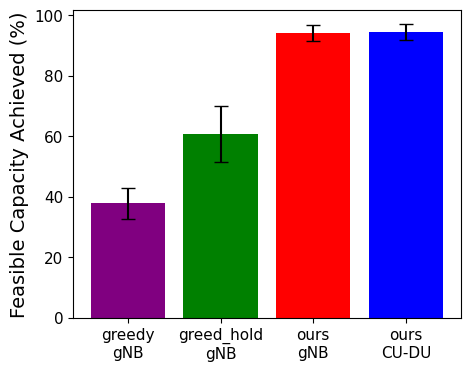

In [8]:
mean_feasible_capacity_achieved = []
std_feasible_capacity_achieved = []

for idx in range(4):
    feasible_capacity = np.array(transfer_per_cell_list[idx]) / (sum(optimal_transfer_list) / len(cell_indices))
    mean_feasible_capacity_achieved.append(np.mean(feasible_capacity, axis=0))
    std_feasible_capacity_achieved.append(np.std(feasible_capacity, axis=0))

mean_feasible_capacity_achieved = np.array(mean_feasible_capacity_achieved) * 100

err_feasible_capacity_achieved = 1.96 * np.array(std_feasible_capacity_achieved) / np.sqrt(len(greedy_cell_indices))

err_feasible_capacity_achieved = np.array(err_feasible_capacity_achieved) * 100

system = ['greedy\ngNB', 'greed_hold\ngNB', 'ours\ngNB', 'ours\nCU-DU']

fig,ax = plt.subplots(figsize=(5,4))

plt.bar(system, mean_feasible_capacity_achieved, yerr=err_feasible_capacity_achieved, color=['purple', 'green', 'red', 'blue'], capsize=5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.xlabel('Algorithm', fontsize=16)
plt.ylabel('Feasible Capacity Achieved (%)', fontsize=14)
plt.savefig('../results/figures/feasible_capacity.eps', format='eps')


In [ ]:
feasible_capacity_list = []
feasible_capacity_cdf_list = []


for i in range(len(transfer_per_cell_list)):
    transfer_per_sat = transfer_per_cell_list[i]

    feasible_capacity_per_sat = transfer_per_sat / (sum(optimal_transfer_list) / len(cell_indices)) * 100
    sorted_feasible_capacity = np.sort(feasible_capacity_per_sat)
    feasible_capacity_list.append(sorted_feasible_capacity)
    # Calculate the CDF

    cdf = np.arange(1, len(sorted_feasible_capacity) + 1) / len(sorted_feasible_capacity)
    feasible_capacity_cdf_list.append(cdf)

cdf = np.arange(1, len(sorted_feasible_capacity) + 1) / len(sorted_feasible_capacity)
feasible_capacity_cdf_list.append(cdf)

# Plot the CDF
plt.plot(feasible_capacity_list[0], feasible_capacity_cdf_list[0], label='greedy/gNB')
plt.plot(feasible_capacity_list[1], feasible_capacity_cdf_list[1], label='greedy_hold/gNB')
plt.plot(feasible_capacity_list[2], feasible_capacity_cdf_list[2], label='ours/gNB')
plt.plot(feasible_capacity_list[3], feasible_capacity_cdf_list[3], label='ours/CU-DU')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Feasible Capacity Achieved (%)', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.legend(fontsize=12)
plt.savefig('../results/figures/feasible_capacity_cdf.eps', format='eps')

### Across handover type

In [9]:
handover_types = ['CU-1', 'DU-1', 'CU-2', 'DU-2']
time_unit = 20 # ms

avg_feasible_rate_list = []

for idx, folder in enumerate(results_dir_list):
    file_dir = results_dir + folder
    change_time = change_time_list[idx]
    change_matrix = change_matrix_list[idx]
    delay_dir = results_dir + delay_dir_list[idx]
    cell_indices = cell_indices_list[idx]
    gw_indices = gw_indices_list[idx]
    assignments = assignments_list[idx]
    handover = handover_types[idx]

    avg_feasible_rate_list.append(get_instant_achieved_capacity(file_dir, cell_indices, gw_indices,
                                                     assignments, time_unit, sim_length,
                                                     optimal_transfer_list, change_time, 
                                                     change_matrix,
                                                     handover, delay_dir))

avg_feasible_rate_list = np.array(avg_feasible_rate_list) * 100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


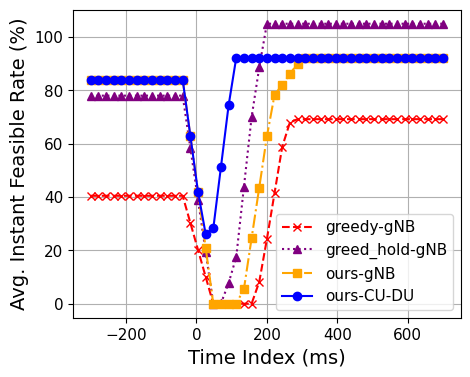

In [10]:
# Plotting line charts for avg_feasible_rate_list
plt.figure(figsize=(5, 4))

colors = ['red', 'purple', 'orange', 'blue']
styles = ['--x', ':^', '-.s', '-o']
system = ['greedy-gNB', 'greed_hold-gNB', 'ours-gNB', 'ours-CU-DU']

for idx, avg_feasible_rate in enumerate(avg_feasible_rate_list):
    plt.plot(np.linspace(-300, 700, len(avg_feasible_rate)), avg_feasible_rate, styles[idx], color=colors[idx], label=f'{system[idx]}')

plt.xlabel('Time Index (ms)', fontsize=14)
plt.ylabel('Avg. Instant Feasible Rate (%)', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True)
plt.savefig('../results/figures/instant_feasible_rate.eps', format='eps')
plt.show()

### Motiv delay architecture

In [11]:
handover_types = ['CU-1', 'CU-2', 'DU-1', 'DU-2']
file_dir = results_dir + holistic_results_dir
change_time = holistic_change_time
change_matrix = holistic_change_matrix
delay_dir = results_dir + holistic_delay_dir
cell_indices = holistic_cell_indices
gw_indices = holistic_gw_indices
assignments = holistic_assignments

time_unit = 20 # ms

avg_feasible_rate_list = []

optimal_transfer_list

for idx, handover in enumerate(handover_types):
    avg_feasible_rate_list.append(get_instant_achieved_capacity(file_dir, cell_indices, gw_indices,
                                                     assignments, time_unit, sim_length,
                                                     optimal_transfer_list, change_time, 
                                                     change_matrix,
                                                     handover, delay_dir))

avg_feasible_rate_list = np.array(avg_feasible_rate_list) * 100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


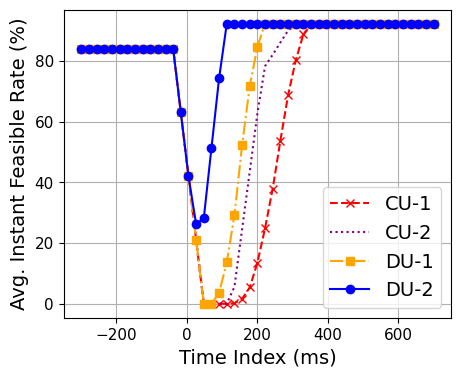

In [12]:
# Plotting line charts for avg_feasible_rate_list
plt.figure(figsize=(5, 4))

colors = ['red', 'purple', 'orange', 'blue']
styles = ['--x', ':', '-.s', '-o']

for idx, avg_feasible_rate in enumerate(avg_feasible_rate_list):
    plt.plot(np.linspace(-300, 700, len(avg_feasible_rate)), avg_feasible_rate, styles[idx], color=colors[idx], label=f'{handover_types[idx]}')

plt.xlabel('Time Index (ms)', fontsize=14)
plt.ylabel('Avg. Instant Feasible Rate (%)', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig('../results/figures/throughput_motiv.eps', format='eps')
plt.show()

## Plot handover delays for motiv

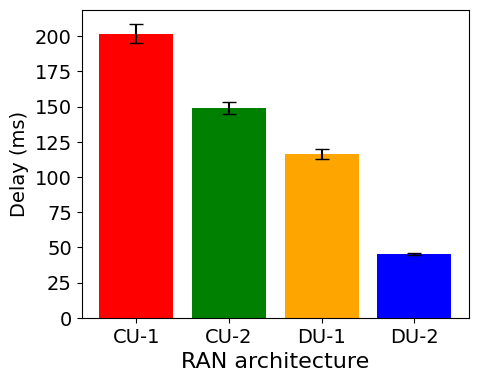

In [13]:
handover_types = ['CU-1', 'CU-2', 'DU-1', 'DU-2']

overall_handover_list = []
for _, handover in enumerate(handover_types):
    delay_dir = results_dir + holistic_delay_dir
    overall_handover_list.append(get_handover_delay_comparison(holistic_cell_indices,
                                                               holistic_gw_indices,
                                                               holistic_assignments,
                                                               holistic_change_time,
                                                               holistic_change_matrix,
                                                               handover,
                                                               delay_dir,
                                                               sim_length))

overall_handover_list = np.array(overall_handover_list)

mean_overall_handover = []
std_overall_handover = []

for idx in range(4):
    mean_overall_handover.append(np.mean(overall_handover_list[idx]))
    std_overall_handover.append(np.std(overall_handover_list[idx]))

err_overall_handover = 1.96 * np.array(std_overall_handover) / np.sqrt(len(holistic_cell_indices))

fig,ax = plt.subplots(figsize=(5,4))

plt.bar(handover_types, mean_overall_handover, yerr=err_overall_handover, color=['red', 'green', 'orange', 'blue'], capsize=5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('RAN architecture', fontsize=16)
plt.ylabel('Delay (ms)', fontsize=14)
plt.savefig('../results/figures/handover_delay_motiv.eps', format='eps')    

## overall delays

In [14]:

results_dir_list = ['greedy_small_2', 'greedy_hold_small_2', 'holistic_small_2']
cell_indices_list = [greedy_cell_indices, greedy_cell_indices, holistic_cell_indices]

hops_algo = []
success_links_algo = []
trace_time_algo = []

for idx, folder in enumerate(results_dir_list):
    trace_time = []
    traceroute_dir = results_dir + folder + '/traceroute/'
    file_list = os.listdir(traceroute_dir)
    traceroute_files = [file for file in file_list if file.startswith('traceroute_')]
    cell_indices = cell_indices_list[idx]
    gw_indices = gw_indices_list[idx]
    assignments = assignments_list[idx]

    total_hops = 0

    for file in traceroute_files:
        trace_time_value = int(file.split('_')[1])
        if trace_time_value not in trace_time:
            trace_time.append(trace_time_value)

    trace_time.sort()
    avg_hops_per_cell = [0 for _ in trace_time]
    success_links = [0 for _ in trace_time]

    sorted_traceroute_files = []

    print (folder)
    for time in trace_time:
        for cell in cell_indices:
            file_prefix = 'traceroute_' + str(time) + '_' + str(cell) + '_'
            for x in traceroute_files:
                if x.startswith(file_prefix):
                    sorted_traceroute_files.append(x)
    
    for file in sorted_traceroute_files:
        time = int(file.split('_')[1])
        with open(traceroute_dir + file, 'r') as f:
            traceroute_output = f.read()
        traceroute_lines = traceroute_output.split('\n')[:-1]
        hops = 0
        failed = 0
        if len(traceroute_lines) < 3:
            failed = 1
            continue

        for line in traceroute_lines[1:]:
            if '*' not in line or ('*' in line and '*' not in traceroute_lines[-1]):
                hops += 1
            elif '*' in line and '*' in traceroute_lines[-1]:
                failed = 1
                break
            
        if failed == 0:
            avg_hops_per_cell[trace_time.index(time)] += hops
            success_links[trace_time.index(time)] += 1

        # if 2 <= len(traceroute_lines) < 3:
        #     print (file)

        # if len(traceroute_lines) > 6:
        #     print (file)

    hops_algo.append(avg_hops_per_cell)
    success_links_algo.append(success_links)
    trace_time_algo.append(trace_time)

for i in range(len(trace_time_algo)):
    trace_time_algo[i] = sorted(trace_time_algo[i])

greedy_small_2
greedy_hold_small_2
holistic_small_2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


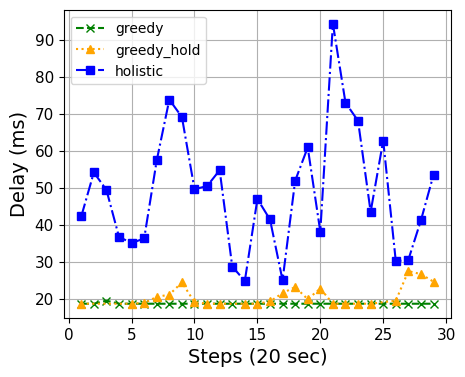

In [15]:
bentpipe_delay = 9.3 # ms
isl_delay = 30.15 # ms

total_hops_algo = []
for idx in range(len(hops_algo)):
    total_hops_algo.append(np.array(hops_algo[idx]) / np.array(success_links_algo[idx]))

total_delay_algo = []
for algo_idx in range(len(hops_algo)):
    algo_delay = []
    for t_idx in range(len(total_hops_algo[algo_idx])):
        hops_num = total_hops_algo[algo_idx][t_idx]
        assert (hops_num >= 2)
        delay = bentpipe_delay * 2 + (hops_num - 2) * isl_delay
        algo_delay.append(delay)

    total_delay_algo.append(algo_delay)

colors = ['green', 'orange', 'blue']
algo = ['greedy', 'greedy_hold', 'holistic']
styles = ['--x', ':^', '-.s']

# Plotting total_hops_algo
plt.figure(figsize=(5, 4))
for idx, delay in enumerate(total_delay_algo):
    plt.plot(trace_time_algo[idx], delay, styles[idx], label=f'{algo[idx]}', color=colors[idx])

plt.xlabel('Steps (20 sec)', fontsize=14)
plt.ylabel('Delay (ms)', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend()
plt.grid(True)
plt.savefig('../results/figures/delay_results.eps', format='eps')
plt.show()

## links load

In [116]:
import re

traceroute_dir = results_dir + 'greedy_hold_small' + '/traceroute/'
file_list = os.listdir(traceroute_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

trace_time = []

for file_name in traceroute_files:
    t = int(file_name.split('_')[1])
    if t not in trace_time:
        trace_time.append(t)
        
trace_time = sorted(trace_time)

total_hops = 0

sat_loads = [[0 for _ in range(76)] for _ in trace_time]
sat_links = [[0 for _ in range(76)] for _ in trace_time]

for file in traceroute_files:
    t = int(file.split('_')[1])
    cell_id = int(file.split('_')[2])
    with open(traceroute_dir + file, 'r') as f:
        traceroute_output = f.read()
        
    traceroute_lines = traceroute_output.split('\n')[:-1]
    if len(traceroute_lines) < 2:
        continue
    
    ip_addresses = []
    for line in traceroute_lines[1:]:
        if '*' not in line:
            ip_address = re.findall(r'\(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\)', line)
        else:
            continue
        ip_addresses.append(ip_address[0].replace('(', '').replace(')', '').split('.'))
    
    for ip in ip_addresses:
        
        if ip[-1] != '10' and int(ip[-2]) < 76:
            sat_links[trace_time.index(t)][int(ip[-2])] += 1
            sat_loads[trace_time.index(t)][int(ip[-2])] += demands[trace_time.index(t), cell_indices.index(cell_id)]
            # sat_loads[trace_time.index(t)][int(ip[-2])] += transfer_matrix_list[2][cell_indices.index(cell_id), trace_time.index(t)] * 8
            
            
    sat_loads = np.array(sat_loads)
    sat_links = np.array(sat_links)



In [ ]:
from matplotlib import cm

import matplotlib.pyplot as plt

# Plot the 3D histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = range(sat_loads.shape[1])
y = range(sat_loads.shape[0])
X, Y = np.meshgrid(x, y)
Z = sat_loads.flatten()

# Define colors based on Z values
colors = cm.plasma(Z / np.max(Z))

ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(Z), 1, 1, Z, color=colors)

# Set labels and title
ax.set_xlabel('Satellite Index')
ax.set_ylabel('Time')
ax.set_zlabel('Satellite Load')
ax.set_title('3D Histogram of Satellite Load')

# Show the plot
plt.savefig('../results/figures/sat_load_greedy_hold.eps', format='eps')

In [ ]:
import matplotlib.pyplot as plt

# Plot the sat_links

plt.imshow(sat_links, cmap='viridis', vmax=16, vmin=0, interpolation='nearest')
plt.xlabel('Satellite Index')
plt.ylabel('Trace Time Index')
plt.title('Satellite Links')
plt.colorbar(label='Number of Links')
plt.savefig('../results/figures/sat_links_greedy_hold.eps', format='eps')

## Network delay

## Unconneted cell rate

In [2]:
satellites_num = 61
link_bandwidth = 1000
dynamic_demands = True
results_dir = '../results/'
demand_ratio = link_bandwidth / 20

gw_antenna_num = 8
AS = [[1, satellites_num + 3 * gw_antenna_num + 147]]
gw_indices = [x for x in range(satellites_num + 1, satellites_num + 3 * gw_antenna_num + 1)]
cell_indices = [x for x in range(satellites_num + 3 * gw_antenna_num + 1, satellites_num + 3 * gw_antenna_num + 1 + 147)]

In [3]:
traceroute_dir = results_dir + 'holistic_small_2' + '/traceroute/'
file_list = os.listdir(traceroute_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

trace_times = []

for file_name in traceroute_files:
    t = int(file_name.split('_')[1])
    if t not in trace_times:
        trace_times.append(t)
        
trace_times = sorted(trace_times)

connected = np.zeros((len(cell_indices), len(trace_times)))

for t in trace_times:
    route_files = [file for file in file_list if file.startswith('traceroute_' + str(t) + '_')]

    for file in route_files:
        cell = int(file.split('_')[2])
        gw = int(file.split('_')[3].split('.')[0])
        with open(traceroute_dir + file, 'r') as f:
            traceroute_output = f.read()
        traceroute_lines = traceroute_output.split('\n')[:-1]

        if len(traceroute_lines) < 2:
            print (file)
            continue

        dst_ip = '9.' + str(gw) + '.' + str(gw) + '.10'

        if dst_ip in traceroute_lines[-1]:
            connected[cell_indices.index(cell), trace_times.index(t)] = 1
        else:
            print (file)


unconnected = 1 - connected

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import matplotlib.pyplot as plt

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the dimensions of the connected array
num_cells = len(cell_indices)
num_times = len(trace_times)

# Create X, Y, and Z arrays for the histogram
X, Y = np.meshgrid(range(num_cells), range(num_times))
Z = unconnected.flatten()

# Define colors based on Z values
colors = cm.viridis(Z / np.max(Z))

# Plot the 3D histogram
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(Z), 1, 1, Z, color=colors)

# Set labels and title
ax.set_xlabel('Cell Index')
ax.set_ylabel('Time Index')
ax.set_zlabel('Connected')
ax.set_title('Color-coded 3D Histogram of Connected')

# Show the plot
plt.savefig('../results/figures/unconnected_holistic.eps', format='eps')

print ("unconnected rate: {} %".format(np.sum(unconnected)/np.sum(np.ones(unconnected.shape))*100))

In [ ]:
sum_connected = np.sum(connected, axis=1)

cdf = np.arange(1, len(sum_connected) + 1) / len(sum_connected)

# Plot the CDF of sum_connected
plt.plot(np.sort(sum_connected), cdf, label='Sum Connected')
plt.xlabel('Sum Connected')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Sum Connected')
plt.show()

In [ ]:
sum_connected = np.sum(connected, axis=0)

cdf = np.arange(1, len(sum_connected) + 1) / len(sum_connected)

# Plot the CDF of sum_connected
plt.plot(np.sort(sum_connected), cdf, label='Sum Connected')
plt.xlabel('Sum Connected')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Sum Connected')
plt.show()


### Number of handovers

In [45]:
results_dir_list = ['greedy_small', 'greedy_hold_small', 'holistic_small']

num_handovers = np.zeros((len(results_dir_list), len(cell_indices)), dtype=int)

for idx, matrix in enumerate(change_matrix_list):
    m = np.array(matrix)

    for t in range(m.shape[1]):
        for cell_idx in range(len(cell_indices)):
            if m[cell_idx, t, 0] != m[cell_idx, t, 1]:
                num_handovers[idx, cell_idx] += 1
    

In [ ]:
# Plotting with dots
styles = ['--bo', '-.g^', '-rd']
for idx, result_dir in enumerate(results_dir_list):
    plt.plot(range(len(cell_indices)), num_handovers[idx], styles[idx], label=result_dir)

plt.xlabel('Cell Index')
plt.ylabel('Number of Handovers')
plt.title('Number of Handovers per Cell')
plt.legend()
plt.savefig('../results/figures/num_handovers.eps', format='eps')

# Test playground

In [28]:
gw_indices = [x for x in range(satellites_num + 1, satellites_num + 6)]
cell_indices = [x for x in range(satellites_num + 6, satellites_num + 50)]
delay_file = results_dir + 'holistic_small_delay/7.txt'

matrix = np.genfromtxt(delay_file, delimiter=',', dtype=float)

In [ ]:
nonzero_indices = np.nonzero(matrix[119])
print(nonzero_indices)

In [ ]:
test_df = pd.read_csv('./sim_configs/small_2/greedy_flows.csv')

test_df.loc[
    (test_df['time'] == 0) &
    (test_df['cell'] == 1)
]['init_demand'].values[0]

In [ ]:
np.array(holistic_change_matrix[0]).shape